In [1]:
import pickle
from collections import Counter
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from DataObjs import Corpus, success_transform, confidence_transform

In [2]:
with open('Data/data_regression.p') as handle:
    raw_data = pickle.load(handle)
    
# length, lex, form -> all, p, e
# data point = (sccss_str, conf_str, ([], [], []), ([], [], []), ([], [], []))     
    
# nonoise
data_en = Corpus(raw_data[1], succs_map=success_transform, conf_map=confidence_transform)
# FTT
data_de = Corpus(raw_data[0], succs_map=success_transform, conf_map=confidence_transform) 

data_all = Corpus(dict(raw_data[0], **raw_data[1]), succs_map=success_transform, conf_map=confidence_transform)

In [ ]:
n = 200
mu = 5
sigma = 1
xs = ((2*sigma + mu) - (mu - 2*sigma))*stats.uniform.rvs(size=(n, 1)) + (mu - 2*sigma)
ys = np.reshape([1 if y > 0.25 else 0 for y in stats.norm.pdf(xs, mu, sigma)], (n, 1))

plt.plot(xs, ys, 'o')


print xs.shape, ys.shape
x_terms = [xs**i for i in range(1, 50)]
x_terms = np.asarray(x_terms).T.reshape(n, 49)

l = LogisticRegression(penalty='l1')
l.fit(x_terms, ys)


print l.coef_
print l.intercept_

logit = lambda x: float(1)/(1+np.e**-(l.intercept_[0] + sum(l.coef_[0][i]*x**(i+1) for i in range(49))))


plotting_range = list(np.arange((mu - 2*sigma), (mu + 2*sigma), 0.1))
fitted = [logit(x) for x in plotting_range]
print fitted

plt.plot(plotting_range, [logit(x) for x in plotting_range])
plt.show()


164 164 164
[87 53 52 51 50 80 46 54 45 42 41 40 39 75 37 86 36 55 57 74 73 72 70 69 68
 56 67 64 62 61 78 59 79 65 35 38 81  5  8  9 10 11  4 14 15 34 17 84 19  7
 21 20  6 85 31 24 25 82 27 22 28  1 30 44 12 32 63 83 47 16  3 48 29 77 76
 13 71 43 33 18 60 66  0 23 49 58  2 26]
88 88 88
[ 0.65        0.93333333  0.84166667  0.64285714  0.25        0.69666667
  0.34722222  0.25        0.75        0.33846154  0.58333333  0.375
  0.53220612  0.66666667  0.33333333  0.53333333  0.55178571  0.5         0.75
  0.66666667]
[ 0.0125      0.01777778  0.0225      0.04251701  0.125       0.04648889
  0.12133488  0.1875      0.0625      0.15136095  0.09722222  0.171875
  0.13548676  0.11111111  0.22222222  0.16        0.15983099  0.25        0.1875
  0.22222222]
[ 0.008125    0.01659259  0.0189375   0.02733236  0.03125     0.03238726
  0.04213017  0.046875    0.046875    0.05122986  0.05671296  0.06445312
  0.07210688  0.07407407  0.07407407  0.08533333  0.08819246  0.125
  0.140625    0.1481481

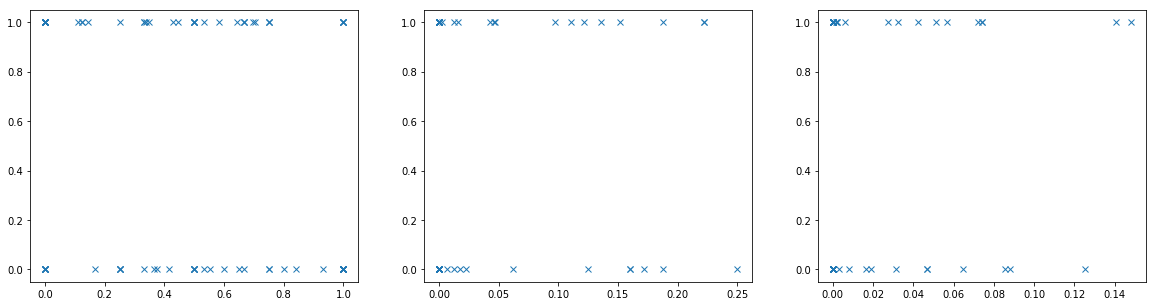

In [21]:
xs_mean = [np.mean(mv.lex_e) for mv in data_all.moves]
xs_var = [np.var(mv.lex_e) for mv in data_all.moves]

ys = [1 if y == 1 else 0 for y in data_all.get_succs()]

print len(xs_mean), len(xs_var), len(ys)

filtered_xs_mean, filtered_xs_var, filtered_ys = list(zip(*[(x_m, x_v, y) for x_m, x_v, y in zip(xs_mean, xs_var, ys) 
                                                              if (not np.isnan(x_m) and not np.isnan(x_v))]))

idx = np.argsort([m*v for m, v in zip(filtered_xs_mean, filtered_xs_var)])

print idx

sorted_xs_mean = np.asarray([filtered_xs_mean[i] for i in list(idx)])
sorted_xs_var = np.asarray([filtered_xs_var[i] for i in list(idx)])
sorted_ys = np.asarray([filtered_ys[i] for i in list(idx)])

print len(sorted_xs_mean), len(sorted_xs_var), len(sorted_ys)

print sorted_xs_mean[-20:]
print sorted_xs_var[-20:]
print (sorted_xs_mean*sorted_xs_var)[-20:]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
ax1.plot(sorted_xs_mean, sorted_ys, 'x')
ax2.plot(sorted_xs_var, sorted_ys, 'x')
ax3.plot((sorted_xs_mean*sorted_xs_var), sorted_ys, 'x')
plt.show()


[[-0.76661227  0.          0.        ]]
[ 0.40436624]
[0.59973624220600064, 0.5812008659964123, 0.56243339478255128]


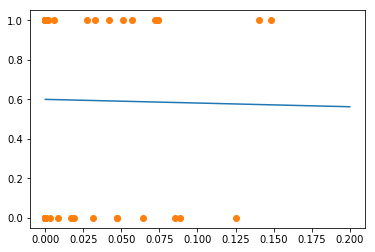

In [31]:
x_terms_mean = [sorted_xs_mean**i for i in range(1, 2)]
x_terms_mean = np.asarray(x_terms_mean).T

x_terms_var = [sorted_xs_var**i for i in range(1, 3)]
x_terms_var = np.asarray(x_terms_var).T

x_terms = np.concatenate([x_terms_mean, x_terms_var], axis=1)



l = LogisticRegression(penalty='l1')
l.fit(x_terms, sorted_ys)

print l.coef_
print l.intercept_

logit = lambda x: float(1)/(1+np.e**-(l.intercept_[0] + sum(l.coef_[0][i]*x**(i+1) for i in range(2))))

plotting_range = list(np.arange(np.min(sorted_xs_var), np.max(sorted_xs_var), 0.1))
fitted = [logit(x) for x in plotting_range]
print fitted

plt.plot(plotting_range, [logit(x) for x in plotting_range])
plt.plot(sorted_xs_mean*sorted_xs_var, sorted_ys, 'o')
plt.show()

In [53]:
# model tests
# -> likelihood-ratio test for 
# H0 := the tested predictor is not necessary; H_alt := the tested predictor achieves significantly better fit
# justification: none of the parameters of the model are unknown (the parameters are the coefficients of the terms), 
# so by the Neyman-Pearson, likelihood-ratio has the greatest power (P(reject H0| H1 is true))

# ß0 + ß1*x + ß2*x^2
x_terms_mean = [sorted_xs_mean**i for i in range(1, 3)]
x_terms_mean = np.asarray(x_terms_mean).T

l = LogisticRegression(penalty='l1')
l.fit(x_terms_mean, sorted_ys)

print 'ß0 + ß1*x + ß2*x^2:', l.intercept_, l.coef_

# ß0 + ß1*x
x_terms_mean = [sorted_xs_mean**i for i in range(1, 2)]
x_terms_mean = np.asarray(x_terms_mean).T
#x_terms = x_terms_mean[:, 0, np.newaxis]

l = LogisticRegression(penalty='l1')
l.fit(x_terms_mean, sorted_ys)
print 'ß0 + ß1*x:', l.intercept_, l.coef_




ß0 + ß1*x + ß2*x^2: [ 0.32733398] [[ 0.        -0.8155307]]
ß0 + ß1*x: [ 0.40437158] [[-0.7666288]]
